# Análise exploratória: série temporal dos dados de postagem dos Correios para o estado do RJ

**Equipe:** Gabriel Miranda, Marcus Thadeu, Ruann Campos, Thiago Caveglion

## Perguntas de negócio:

Marcus:
* Qual a distribuição dos valores de postagem?
* Qual a média de postagem e o ticket médio por cliente?
* Qual a distribuição de postagem por mês, dia e dia da semana?
* Qual o ticket médio por cliente e tipo de serviço?
* O valor médio do serviço "EXPRESSO" é significativamente diferente do valor médio do serviço "ECONÔMICO"?
---
Thiago:
* O valor das postagens é maior na Segunda-feira?
* A média de postagens na Segunda-Feira é significativamente diferente da média de postagens no restante da semana?
* O valor médio do número de postagens mais baratas que 20 reais é significativamente diferente do valor médio do número de postagens mais caras que 20 reais?
* A média de postagens nos primeiros 15 dias é significativamente diferente da média de postagens no restante do mês?
---
Gabriel:
* Qual a distribuição do número de postagens por estado?
* Percentualmente, o quão varia o número de postagens entre os estados do sudeste?
* Como se caracteriza a distribuição de valores de postagem para os estados da região sudeste?
* A média de valor dos pacotes enviados para dentro do estado do RJ é igual à média dos pacotes enviados para outros estados do Brasil?
* A média de valor dos pacotes enviados para dentro do estado do RJ é igual à média dos pacotes enviados para outros estados do Sudeste?
* A média de valor dos pacotes enviados para o ES é igual à média dos pacotes enviados para SP?
---
Ruann:
*   O ticket médio da região Norte é significativamente diferente do ticket médio da região Nordeste?
---

# Tratando o dataframe

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
import os
import locale
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_parquet(r'/content/drive/MyDrive/Coders_Estatistica/operations_base.parquet')
# df.head()

df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/santander-coders-2023/projetos/estatistica1/operations_base.parquet")
df.head()

,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF
0,2023-01-02,QW184224840RJ,27143610,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
1,2023-01-02,QW184224874RJ,26160210,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
2,2023-01-02,QW184224868RJ,23535370,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
3,2023-01-02,QW184224893RJ,27321640,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
4,2023-01-02,QW184227030RJ,23530816,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ


In [ ]:
# Excluindo datas sem informação de valor:
# df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)
# df = df.loc[df['Data'] != '2023-09-15']
# df = df.loc[df['Data'] != '2023-09-18']

# Excluindo outliers:
# df = df.loc[df['Valor'] < 300]

# Salvando o novo dataframe:
# df.to_parquet(r'/content/drive/MyDrive/Coders_Estatistica/operations_base.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831334 entries, 0 to 848389
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Data      831334 non-null  datetime64[ns]
 1   Objeto    831334 non-null  object        
 2   CEP       831334 non-null  object        
 3   Serviço   831334 non-null  object        
 4   Valor     831334 non-null  float64       
 5   Cliente   831334 non-null  object        
 6   Postagem  831334 non-null  object        
 7   Destino   831334 non-null  object        
 8   UF        831334 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 63.4+ MB


In [ ]:
# Transformando a coluna de data para datetime:
df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)

In [ ]:
# Verificando dados nulos:
df.isnull().sum()

Data        0
Objeto      0
CEP         0
Serviço     0
Valor       0
Cliente     0
Postagem    0
Destino     0
UF          0
dtype: int64

In [ ]:
# Verificando linhas duplicados:
df.duplicated().sum()

0

# 1. Valores de postagem, ticket médio por cliente e tipos de serviço (Marcus)

In [ ]:
df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)
timeline_postagem = df.groupby('Data')['Objeto'].count()
timeline_postagem = timeline_postagem.sort_index()

faturamento = df.groupby('Data')['Valor'].sum()

servicos = df.Serviço.unique()
postagem = df.Postagem.unique()
destino = df.Destino.unique()

servico_counts = {}
postagem_counts = {}
destino_counts = {}
triagem_counts = {}

for i in servicos:
    servico_counts[i] = df.loc[df['Serviço'] == i].groupby('Data')['Serviço'].count()

for i in postagem:
    postagem_counts[i] = df.loc[df['Postagem'] == i].groupby('Data')['Postagem'].count()

for i in destino:
    destino_counts[i] = df.loc[df['Destino'] == i].groupby('Data')['Destino'].count()


df_servico = pd.DataFrame(servico_counts).reset_index()
df_postagem = pd.DataFrame(postagem_counts).reset_index()
df_destino = pd.DataFrame(destino_counts).reset_index()

df_servico.rename(columns={'index': 'Data'}, inplace=True)
df_postagem.rename(columns={'index': 'Data'}, inplace=True)
df_destino.rename(columns={'index': 'Data'}, inplace=True)

df_merged  = df_servico.merge(df_postagem, on='Data', how='outer')
df_merged = df_merged.merge(df_destino, on='Data', how='outer')
df_merged.fillna(0, inplace=True)

df_merged["Dia"] =[valor.day for valor in df_merged['Data']]
df_merged["Mes"] =[valor.month for valor in df_merged['Data']]

df_somatorio_por_mes = df_merged.groupby('Mes').sum()
df_somatorio_por_dia = df_merged.groupby('Dia').sum()

colunas = ['EXPRESSO', 'ECONÔMICO', 'MANUAL', 'AUTOMÁTICO', 'RIO DE JANEIRO', 'OUTROS ESTADOS']

for coluna in colunas:
    df_merged[f'{coluna}_Cumulativa'] = df_merged[coluna].cumsum()

df_somatorio_por_mes['Total de Objetos'] = df_somatorio_por_mes['EXPRESSO'] + df_somatorio_por_mes['ECONÔMICO']
df_somatorio_por_dia['Total de Objetos'] = df_somatorio_por_dia['EXPRESSO'] + df_somatorio_por_dia['ECONÔMICO']

df_merged['Dia da Semana'] = [valor.weekday() for valor in df_merged['Data']]
dias_da_semana = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}

df_merged['Dia da Semana'] = df_merged['Dia da Semana'].map(dias_da_semana)


In [ ]:
df_merged.head()

,Data,EXPRESSO,ECONÔMICO,MANUAL,AUTOMÁTICO,RIO DE JANEIRO,OUTROS ESTADOS,Dia,Mes,EXPRESSO_Cumulativa,ECONÔMICO_Cumulativa,MANUAL_Cumulativa,AUTOMÁTICO_Cumulativa,RIO DE JANEIRO_Cumulativa,OUTROS ESTADOS_Cumulativa,Dia da Semana
0,2023-01-02,2241,482,2718,5,789,1934,2,1,2241,482,2718,5,789,1934,Segunda-feira
1,2023-01-03,2004,997,2887,114,985,2016,3,1,4245,1479,5605,119,1774,3950,Terça-feira
2,2023-01-04,2150,666,2723,93,902,1914,4,1,6395,2145,8328,212,2676,5864,Quarta-feira
3,2023-01-05,2309,697,2964,42,933,2073,5,1,8704,2842,11292,254,3609,7937,Quinta-feira
4,2023-01-06,2450,861,3059,252,1038,2273,6,1,11154,3703,14351,506,4647,10210,Sexta-feira


In [ ]:
df_merged.describe()

,EXPRESSO,ECONÔMICO,MANUAL,AUTOMÁTICO,RIO DE JANEIRO,OUTROS ESTADOS,Dia,Mes,EXPRESSO_Cumulativa,ECONÔMICO_Cumulativa,MANUAL_Cumulativa,AUTOMÁTICO_Cumulativa,RIO DE JANEIRO_Cumulativa,OUTROS ESTADOS_Cumulativa
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,2253.165746,2339.839779,2724.950276,1868.055249,2230.005525,2363.000000,15.624309,4.922652,190730.497238,194098.596685,233287.464088,151541.629834,185758.331492,199070.762431
std,875.590528,1125.803689,991.314006,1437.246579,1128.966501,885.993372,8.807337,2.519829,108297.747906,124116.028871,131907.636974,101098.032916,115701.063177,116634.394155
min,814.000000,482.000000,1073.000000,5.000000,642.000000,1070.000000,1.000000,1.000000,2241.000000,482.000000,2718.000000,5.000000,789.000000,1934.000000
25%,1620.000000,1543.000000,1911.000000,948.000000,1442.000000,1736.000000,8.000000,3.000000,105110.000000,78701.000000,132391.000000,51420.000000,79050.000000,104761.000000
50%,2054.000000,2110.000000,2694.000000,1469.000000,2049.000000,2161.000000,15.000000,5.000000,178169.000000,196531.000000,218276.000000,156424.000000,191629.000000,183071.000000
75%,2689.000000,2877.000000,3365.000000,2407.000000,2702.000000,2785.000000,23.000000,7.000000,283701.000000,301070.000000,330355.000000,254416.000000,282297.000000,302474.000000
max,5407.000000,6899.000000,6228.000000,7086.000000,7069.000000,5821.000000,31.000000,9.000000,407823.000000,423511.000000,493216.000000,338118.000000,403631.000000,427703.000000


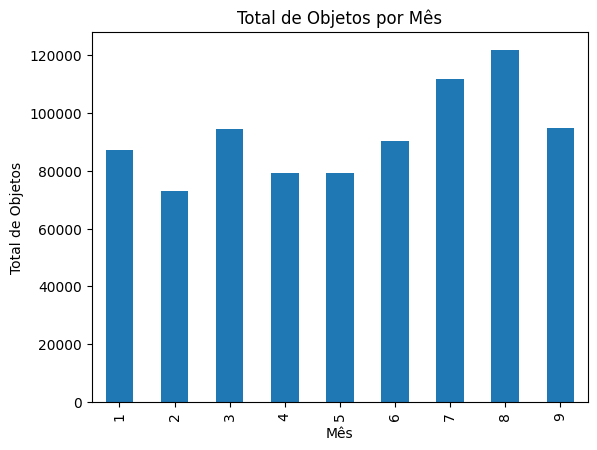

In [ ]:
df_somatorio_por_mes['Total de Objetos'].plot(kind='bar', xlabel='Mês', ylabel='Total de Objetos', title='Total de Objetos por Mês')
plt.show()

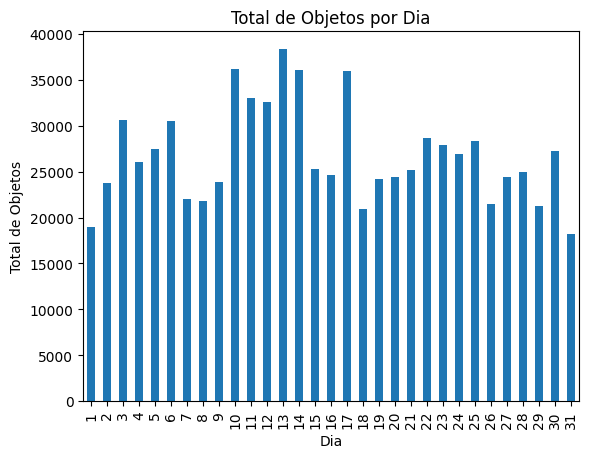

In [ ]:
df_somatorio_por_dia['Total de Objetos'].plot(kind='bar', xlabel='Dia', ylabel='Total de Objetos', title='Total de Objetos por Dia')
plt.show()

In [ ]:
expresso = df[df['Serviço'] == 'EXPRESSO']['Valor']
outro_servico = df[df['Serviço'] != 'EXPRESSO']['Valor']

t_stat, p_value = stats.ttest_ind(expresso, outro_servico)

if p_value < 0.05:
    print(f"Há evidências para rejeitar a hipótese nula - {p_value}")
else:
    print(f"Não há evidências para rejeitar a hipótese nula - {p_value}")



Há evidências para rejeitar a hipótese nula - 0.0


In [ ]:
media_valores_ordenados=np.mean(df['Valor'])
mediana_valores_ordenados = np.median(df['Valor'])
moda_valores_ordenados = stats.mode(df['Valor'])[0]

In [ ]:
df_merged.columns

Index(['Data', 'EXPRESSO', 'ECONÔMICO', 'MANUAL', 'AUTOMÁTICO',
       'RIO DE JANEIRO', 'OUTROS ESTADOS', 'Dia', 'Mes', 'EXPRESSO_Cumulativa',
       'ECONÔMICO_Cumulativa', 'MANUAL_Cumulativa', 'AUTOMÁTICO_Cumulativa',
       'RIO DE JANEIRO_Cumulativa', 'OUTROS ESTADOS_Cumulativa',
       'Dia da Semana'],
      dtype='object')

Qual a distribuição dos valores de postagem?

Qual o ticket médio por cliente?

Qual o ticket médio tipo de serviço?

Qual a distribuição de postagem por mês, dia e dia da semana?

O valor médio do serviço "EXPRESSO" é significativamente diferente do valor médio do serviço "ECONÔMICO"?



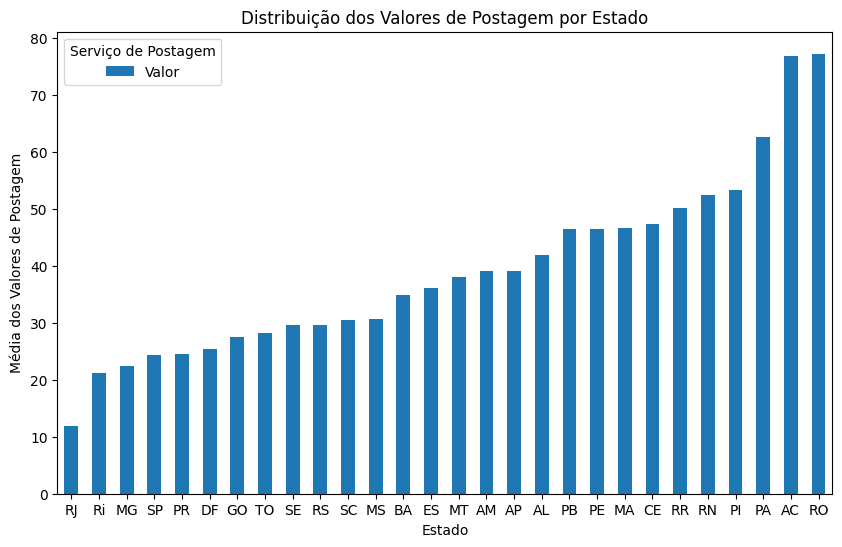

In [ ]:
media_por_estado = df.groupby('UF')[['Valor']].mean().sort_values(by='Valor')

media_por_estado.plot(kind='bar', figsize=(10, 6))
plt.title('Distribuição dos Valores de Postagem por Estado')
plt.xlabel('Estado')
plt.ylabel('Média dos Valores de Postagem')
plt.xticks(rotation=0)  # Para manter os rótulos dos estados legíveis
plt.legend(title='Serviço de Postagem')

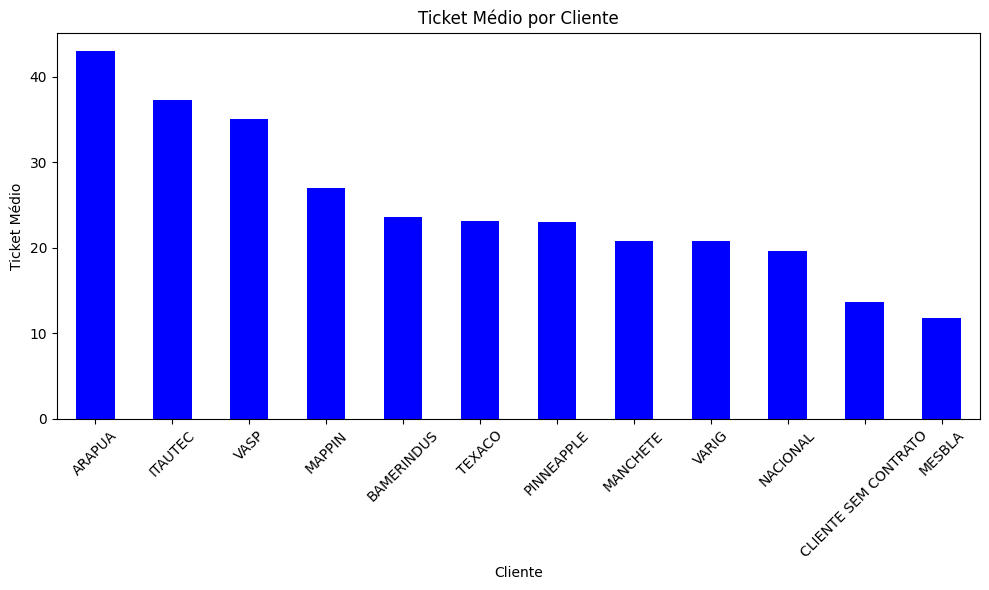

Cliente
ARAPUA                  42.984281
ITAUTEC                 37.234416
VASP                    35.078816
MAPPIN                  27.004330
BAMERINDUS              23.640075
TEXACO                  23.081995
PINNEAPPLE              22.976110
MANCHETE                20.832721
VARIG                   20.806970
NACIONAL                19.616630
CLIENTE SEM CONTRATO    13.655603
MESBLA                  11.758024
Name: Valor, dtype: float64

In [ ]:
ticket_medio_por_cliente = df.groupby('Cliente')['Valor'].mean()
ticket_medio_por_cliente = ticket_medio_por_cliente.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ticket_medio_por_cliente.plot(kind='bar', color='blue')
plt.xlabel('Cliente')
plt.ylabel('Ticket Médio')
plt.title('Ticket Médio por Cliente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ticket_medio_por_cliente

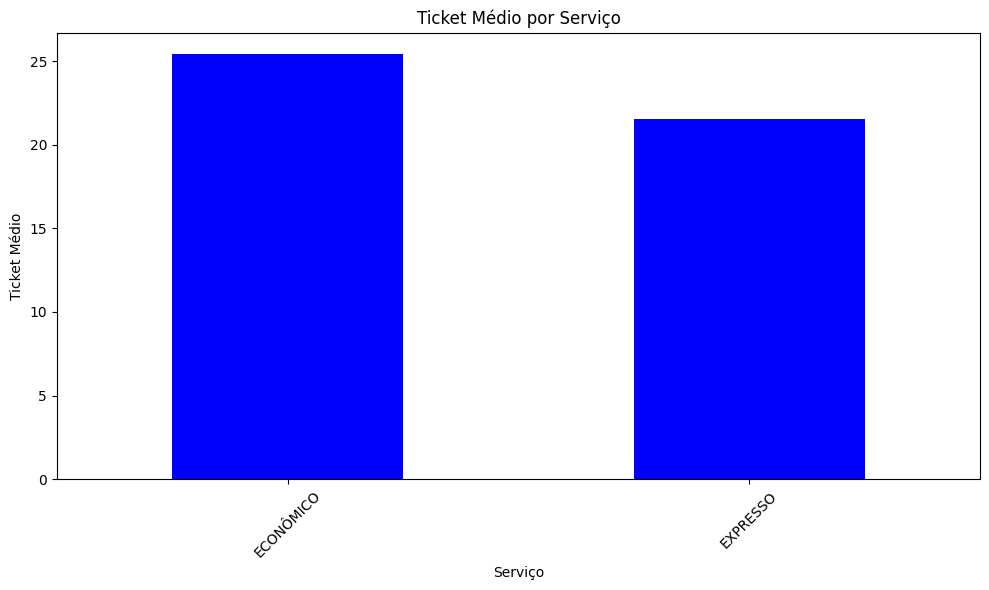

Serviço
ECONÔMICO    25.421887
EXPRESSO     21.562288
Name: Valor, dtype: float64

In [ ]:
ticket_medio_por_servico = df.groupby('Serviço')['Valor'].mean()
ticket_medio_por_servico = ticket_medio_por_servico.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ticket_medio_por_servico.plot(kind='bar', color='blue')
plt.xlabel('Serviço')
plt.ylabel('Ticket Médio')
plt.title('Ticket Médio por Serviço')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ticket_medio_por_servico

# 2. Análise mensal e semanal (Thiago)
---

### * O valor das postagens é maior na Segunda-feira?

### * A média de postagens na Segunda-Feira é significativamente diferente da média de postagens no restante da semana?

### * O valor médio do número de postagens mais baratas que 20 reais é significativamente diferente do valor médio do número de postagens mais caras que 20 reais?

### * A média de postagens nos primeiros 15 dias é significativamente diferente da média de postagens no restante do mês?

---

## Primeiros passos

### Primeiro realiza-se a importação das bibliotecas necessárias e a importação do banco de dados

In [5]:
# from google.colab import drive # utilizado para
# drive.mount('/content/drive') # processos utilizados para utilizar os recursos do drive no collab
import pandas as pd
import os
import locale
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import datetime

warnings.filterwarnings("ignore")



### Nesse caso os dados serão carregados localmente para viabilizar a reprodutibilidade do projeto, mesmo que o fluxo de trabalho tenha sido realizado no colab

In [6]:
# df = pd.read_parquet(r'/content/drive/MyDrive/Coders_Estatistica/operations_base.parquet') caminho utilizado no drive

# necessário instalar pyarrow e fastparquet
df = pd.read_parquet(r'operations_base.parquet') # arquivo geral
df.head() # verificando o comeco do dataframe


,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF
0,02/01/2023,QW184224840RJ,27143610,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
1,02/01/2023,QW184224874RJ,26160210,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
2,02/01/2023,QW184224868RJ,23535370,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
3,02/01/2023,QW184224893RJ,27321640,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
4,02/01/2023,QW184227030RJ,23530816,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ


### Lendo o arquivo parquet utilizando a funcao do pandas

In [ ]:
# df_thiago = pd.read_parquet(r'operations_base.parquet')
df_thiago = df.copy()

### Fazendo o tratamento de dados para incluir na tabela o dia da semana correspondente

In [ ]:
df_thiago["Data"] = pd.to_datetime(df_thiago["Data"], dayfirst=True)

df_thiago['Dia da Semana'] = [valor.weekday() for valor in df_thiago['Data']]
dias_da_semana = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}

df_thiago['Dia da Semana'] = df_thiago['Dia da Semana'].map(dias_da_semana)

df_thiago["Dia da Semana"].unique()

array(['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira',
       'Sexta-feira'], dtype=object)

## * O valor das postagens é maior na Segunda-feira?

### Verificaremos se o valor é maior na segunda feira observando, primeiramente, a média dos valores por dia da semana. Nota-se que segunda e sexta feira possuem postagens em média 10% mais caras que os outros dias da semana.

In [ ]:
gb_dia = df_thiago.groupby("Dia da Semana")
media_val_dias_da_semana = gb_dia["Valor"].agg(["mean"]).reset_index()
media_val_dias_da_semana.rename(columns={"mean" : "Média dos Valores"}, inplace=True)
media_val_dias_da_semana


,Dia da Semana,Média dos Valores
0,Quarta-feira,22.693718
1,Quinta-feira,22.845689
2,Segunda-feira,25.042852
3,Sexta-feira,25.387627
4,Terça-feira,23.892965


### Plotando em um gráfico pode-se notar que a diferença não é tão expressiva assim, apesar de existir

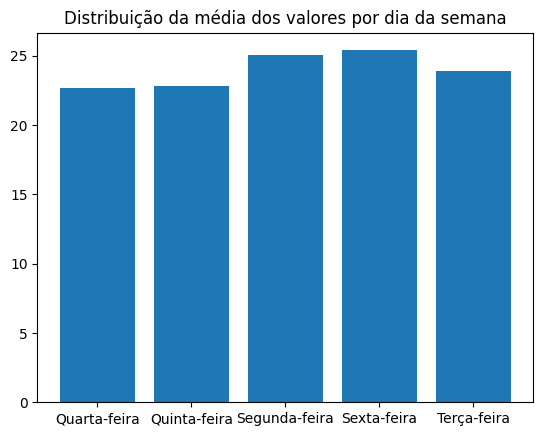

In [ ]:
plt.figure()
plt.title("Distribuição da média dos valores por dia da semana")
plt.bar(media_val_dias_da_semana["Dia da Semana"], media_val_dias_da_semana["Média dos Valores"])
plt.show()

### Olhando por um outro lado, percebe-se diferença expressiva no somatório de todos os valores e, como o valor da postagem não parece ter uma variação muito expressiva, imagina-se que essa diferença esteja puramente na quantidade maior de postagens na segunda-feira.

In [ ]:
gb_dia = df_thiago.groupby("Dia da Semana")
somatorio_val_dias_da_semana = gb_dia["Valor"].agg(["sum"]).reset_index()
somatorio_val_dias_da_semana.rename(columns={"sum" : "Soma dos Valores"}, inplace=True)
somatorio_val_dias_da_semana


,Dia da Semana,Soma dos Valores
0,Quarta-feira,3825094.28
1,Quinta-feira,3458494.58
2,Segunda-feira,5585607.88
3,Sexta-feira,3490747.92
4,Terça-feira,4011915.53


### Novamente, observa-se isso com o gráfico abaixo. Após essa análise, faz sentido perguntar se, de fato, existem mais postagens na segunda feira. Isso será analisado na próxima pergunta.

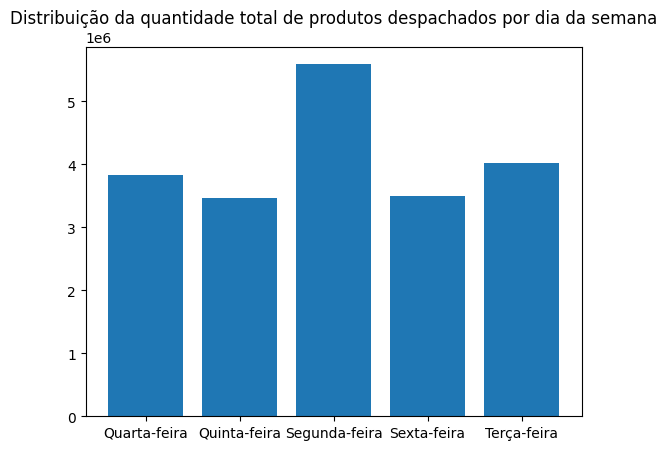

In [ ]:
plt.figure()
plt.title("Distribuição da quantidade total de produtos despachados por dia da semana")
plt.bar(somatorio_val_dias_da_semana["Dia da Semana"], somatorio_val_dias_da_semana["Soma dos Valores"])
plt.show()

## * A média de postagens na Segunda-Feira é significativamente diferente da média de postagens no restante da semana?

### Vamos identificar o número total de postagens por dia de semana e visualizar isso em um gráfico para tentar visualizar se segunda possui mais ocorrências que o resto.

In [ ]:
gb_dia_mes_ano = df_thiago.groupby("Dia da Semana")
quantidade_por_dia = gb_dia_mes_ano["Data"].agg(["count"]).reset_index()
quantidade_por_dia.rename(columns={"count" : "Postagens"}, inplace=True)
quantidade_por_dia

,Dia da Semana,Postagens
0,Quarta-feira,168553
1,Quinta-feira,151385
2,Segunda-feira,223042
3,Sexta-feira,137498
4,Terça-feira,167912


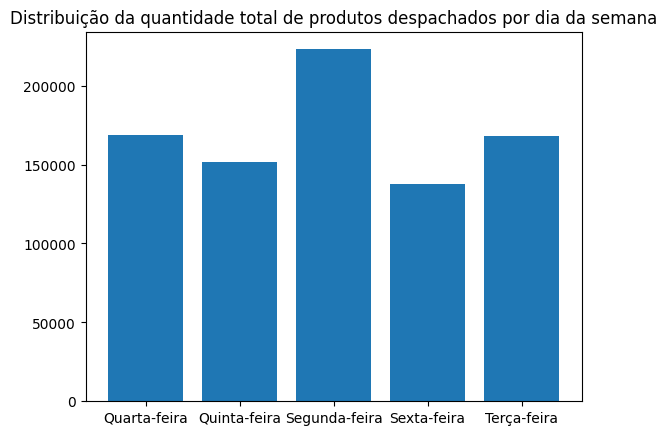

In [ ]:
plt.figure()
plt.title("Distribuição da quantidade total de produtos despachados por dia da semana")
plt.bar(quantidade_por_dia["Dia da Semana"], quantidade_por_dia["Postagens"])
plt.show()

### Observamos anteriormente com esse mesmo gráfico que a quantidade total de produtos postados na segunda feira é consideravelmente maior que o resto dos dias. Consideraremos agora as médias diárias.

In [ ]:
gb_quantidade_dias = df_thiago.groupby("Dia da Semana")["Data"].nunique()
gb_quantidade_dias["Quarta-feira"]

38

In [ ]:
dict_postagens_por_dia_da_semana = {dia: df_thiago[df_thiago["Dia da Semana"] == dia]["Data"].count() for dia in df_thiago["Dia da Semana"].unique()}
dict_postagens_por_dia_da_semana

{'Segunda-feira': 223042,
 'Terça-feira': 167912,
 'Quarta-feira': 168553,
 'Quinta-feira': 151385,
 'Sexta-feira': 137498}

In [ ]:
media_quantidade_dia_da_semana = {dia : round(dict_postagens_por_dia_da_semana[dia]/gb_quantidade_dias[dia], 2) for dia in dict_postagens_por_dia_da_semana.keys()}
media_quantidade_dia_da_semana

{'Segunda-feira': 6028.16,
 'Terça-feira': 4538.16,
 'Quarta-feira': 4435.61,
 'Quinta-feira': 4205.14,
 'Sexta-feira': 3928.51}

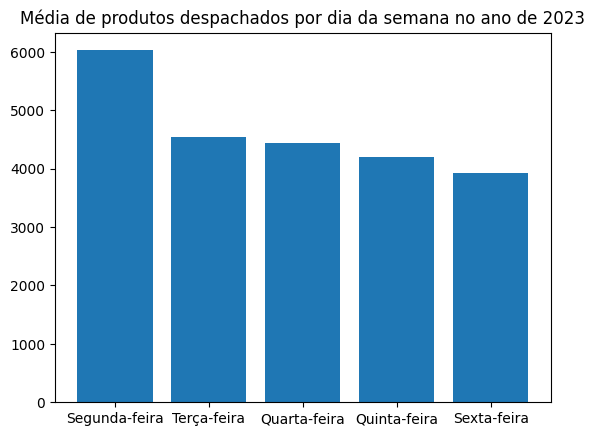

In [ ]:
plt.figure()
plt.title("Média de produtos despachados por dia da semana no ano de 2023")
plt.bar(media_quantidade_dia_da_semana.keys(), media_quantidade_dia_da_semana.values())
plt.show()

### Por conta dessa visualização podemos afirmar que, pelo menos no ano de 2023, existe uma tendência de existir mais produtos despachados na segunda. Por conclusão prática, entende-se que essa maior frequência dos produtos vem do fato das encomendas do fim de semana se acumularem na segunda feira.

## * O valor médio do número de postagens mais baratas que 20 reais é significativamente diferente do valor médio do número de postagens mais caras que 20 reais?


### Vamos analisar a frequência dos valores de postagem

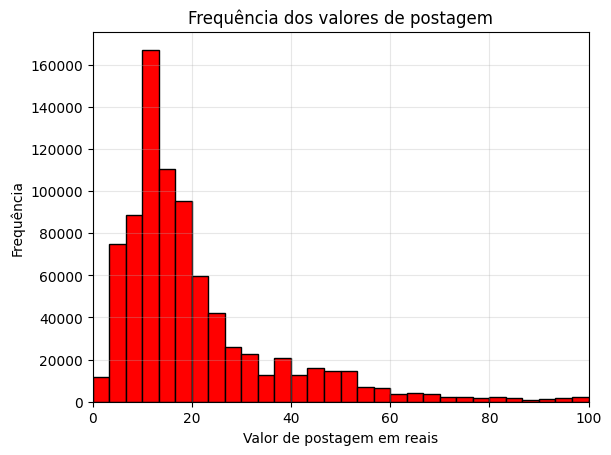

In [ ]:
plt.figure()
df_thiago["Valor"].plot(kind="hist", bins=3000, edgecolor="black", color="red")
plt.xlabel("Valor de postagem em reais")
plt.ylabel("Frequência")
plt.title("Frequência dos valores de postagem")
plt.grid(alpha=0.3)
plt.xlim(0, 100)
plt.show()

### Percebemos que existe uma maior frequência de valores menores que 20 reais. Será que existe alguma relação disso com os dias da semana? Vamos tentar pensar nesse sentido.

In [ ]:
df_menores_que_20 = df_thiago[df_thiago["Valor"] <= 20]
df_menores_que_20

,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF,Dia da Semana
0,2023-01-02,QW184224840RJ,27143610,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
1,2023-01-02,QW184224874RJ,26160210,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
2,2023-01-02,QW184224868RJ,23535370,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
3,2023-01-02,QW184224893RJ,27321640,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
4,2023-01-02,QW184227030RJ,23530816,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
...,...,...,...,...,...,...,...,...,...,...
848383,2023-09-25,VE718227413RJ,24320570,EXPRESSO,15.05,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
848384,2023-09-25,VE718227407RJ,24070110,EXPRESSO,12.87,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
848385,2023-09-25,VE718227431RJ,20511280,EXPRESSO,14.40,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
848387,2023-09-25,VE718227444RJ,20031007,EXPRESSO,13.05,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira


### Filtrando os dataframes para valores menores e maiores que 20

In [ ]:
df_maiores_que_20 = df_thiago[df_thiago["Valor"] > 20]
df_maiores_que_20

,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF,Dia da Semana
75,2023-01-02,QU352763115RJ,41334230,EXPRESSO,34.23,MANCHETE,MANUAL,OUTROS ESTADOS,BA,Segunda-feira
76,2023-01-02,QU352760889RJ,60015221,EXPRESSO,39.94,MANCHETE,MANUAL,OUTROS ESTADOS,CE,Segunda-feira
77,2023-01-02,QU352760895RJ,40420190,EXPRESSO,34.23,MANCHETE,MANUAL,OUTROS ESTADOS,BA,Segunda-feira
78,2023-01-02,QU352760827RJ,92717400,EXPRESSO,26.63,MANCHETE,MANUAL,OUTROS ESTADOS,RS,Segunda-feira
79,2023-01-02,QU352760833RJ,91790300,EXPRESSO,26.63,MANCHETE,MANUAL,OUTROS ESTADOS,RS,Segunda-feira
...,...,...,...,...,...,...,...,...,...,...
848379,2023-09-25,VE718227554RJ,24240182,EXPRESSO,21.12,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
848380,2023-09-25,VE718227573RJ,22783124,EXPRESSO,22.01,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
848382,2023-09-25,VE718227582RJ,22745270,EXPRESSO,20.07,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira
848386,2023-09-25,VE718227422RJ,23555145,EXPRESSO,22.44,NACIONAL,MANUAL,RIO DE JANEIRO,RJ,Segunda-feira


### Agruparemos então o somatório das quantidades filtrados por dia da semana

In [ ]:
df_quantidade_de_postagens_menores_que_20 = df_menores_que_20.groupby("Dia da Semana")["Dia da Semana"].agg(["count"]).reset_index()
df_quantidade_de_postagens_menores_que_20.rename(columns={"count":"Postagens < 20"}, inplace=True)
df_quantidade_de_postagens_menores_que_20

,Dia da Semana,Postagens < 20
0,Quarta-feira,113344
1,Quinta-feira,100795
2,Segunda-feira,139418
3,Sexta-feira,90330
4,Terça-feira,104117


In [ ]:
df_quantidade_de_postagens_maiores_que_20 = df_maiores_que_20.groupby("Dia da Semana")["Dia da Semana"].agg(["count"]).reset_index()
df_quantidade_de_postagens_maiores_que_20.rename(columns={"count":"Postagens > 20"}, inplace=True)
df_quantidade_de_postagens_maiores_que_20

,Dia da Semana,Postagens > 20
0,Quarta-feira,55209
1,Quinta-feira,50590
2,Segunda-feira,83624
3,Sexta-feira,47168
4,Terça-feira,63795


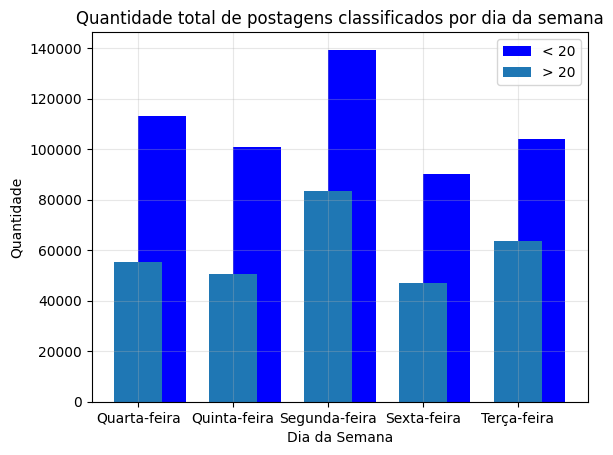

In [ ]:
plt.figure()
plt.grid(alpha=0.3)
valores_menores = plt.bar(df_quantidade_de_postagens_menores_que_20["Dia da Semana"], df_quantidade_de_postagens_menores_que_20["Postagens < 20"], color="blue", width=0.5, align="edge")
valores_maiores = plt.bar(df_quantidade_de_postagens_maiores_que_20["Dia da Semana"], df_quantidade_de_postagens_maiores_que_20["Postagens > 20"], width=0.5)
valores_maiores.set_label("> 20")
valores_menores.set_label("< 20")
plt.legend()
plt.title("Quantidade total de postagens classificados por dia da semana")
plt.ylabel("Quantidade")
plt.xlabel("Dia da Semana")
plt.show()

### Começaremos, então, analisando a segunda feira (dia de maior despachamento de itens).

### Agrupando por quantidade de postagens a cada segunda

In [ ]:
df_segundas_menores = df_thiago[(df_thiago["Dia da Semana"] == "Segunda-feira") & (df_thiago["Valor"] <= 20)]
df_quantidade_postagens_segunda_menor_que_20 = df_segundas_menores.groupby("Data")["Data"].agg(["count"]).reset_index()
df_quantidade_postagens_segunda_menor_que_20.rename(columns={"count":"Postagens < 20"}, inplace=True)
df_quantidade_postagens_segunda_menor_que_20.head()

,Data,Postagens < 20
0,2023-01-02,1049
1,2023-01-09,2589
2,2023-01-16,2356
3,2023-01-23,4234
4,2023-01-30,4184


In [ ]:
df_segundas_maiores = df_thiago[(df_thiago["Dia da Semana"] == "Segunda-feira") & (df_thiago["Valor"] > 20)]
df_quantidade_postagens_segunda_maior_que_20 = df_segundas_maiores.groupby("Data")["Data"].agg(["count"]).reset_index()
df_quantidade_postagens_segunda_maior_que_20.rename(columns={"count":"Postagens > 20"}, inplace=True)
df_quantidade_postagens_segunda_maior_que_20.head()

,Data,Postagens > 20
0,2023-01-02,1675
1,2023-01-09,3528
2,2023-01-16,2699
3,2023-01-23,3845
4,2023-01-30,1999


### Nesse contexto temos:
### H0 (hipótese nula): A quantidade de postagens que custam menos que 20 reais efetuadas na segunda feira é igual à quantidade de postagens que custam mais de 20 reais efetuadas na segunda feira
### Ha (hipótese alternativa): A quantidade de postagens que custam menos que 20 reais efetuadas na segunda feira é diferente (maior ou menor) que a quantidade de postagens que custam mais de 20 reais efetuadas na segunda feira.
### Nível de significância: 0.05 (5%)

In [ ]:
quantidades_menores_que_20_segunda = df_quantidade_postagens_segunda_menor_que_20["Postagens < 20"]
quantidades_maiores_que_20_segunda = df_quantidade_postagens_segunda_maior_que_20["Postagens > 20"]

t_stat, p_value = stats.ttest_ind(quantidades_menores_que_20_segunda, quantidades_maiores_que_20_segunda)
print(f"t_stat: {t_stat}\np_value: {p_value}")

alpha = 0.05

if p_value < alpha: print("Rejeita-se H0")
else: print("Aceita-se H0")

t_stat: 5.449736436823177
p_value: 6.703183434623123e-07
Rejeita-se H0


### Portanto, conclui-se que existe diferença entre a quantidade de produtos cuja postagem custa menos de 20 reais e a quantidade de produtos cuja postagem custa mais que 20 reais.

### Agora vamos visualizar a quantidade de produtos vendidos por segunda feira, separando-os nas categorias "menores que 20 reais" e "maiores que 20 reais"

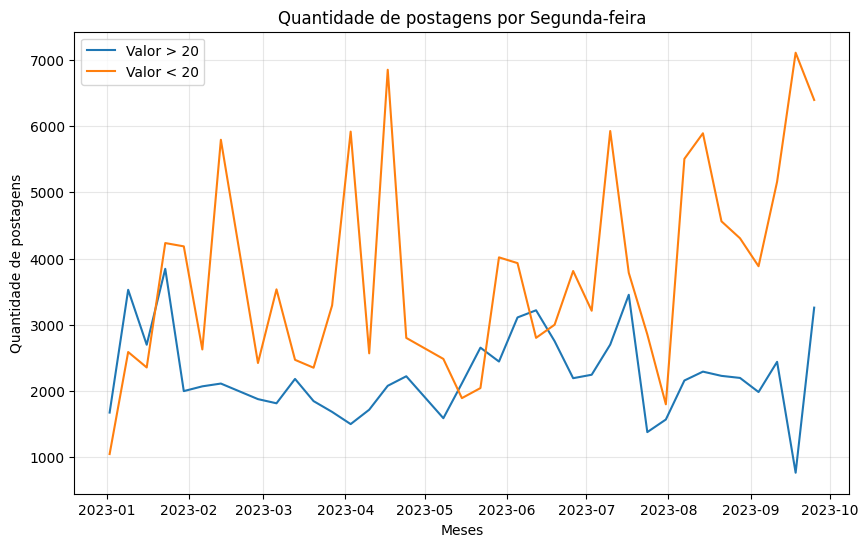

In [ ]:
datas = df_quantidade_postagens_segunda_maior_que_20["Data"]

plt.figure(figsize=(10, 6))
plt.grid(alpha=0.3)
linha1, = plt.plot(datas, df_quantidade_postagens_segunda_maior_que_20["Postagens > 20"])
linha2, = plt.plot(datas, df_quantidade_postagens_segunda_menor_que_20["Postagens < 20"])
plt.title("Quantidade de postagens por Segunda-feira")
plt.ylabel("Quantidade de postagens")
plt.xlabel("Meses")
linha1.set_label("Valor > 20")
linha2.set_label("Valor < 20")
plt.legend()
plt.show()

### Com base no gráfico, podemos afirmar que a quantidade de produtos mais baratos que 20 reais é predominante nas segundas.

### Vamos agora realizar os testes de hipótese para os outros dias da semana.

In [ ]:
dias = ["Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira"]

for dia in dias:
    df_menores = df_thiago[(df_thiago["Dia da Semana"] == dia) & (df_thiago["Valor"] <= 20)]
    df_qtd_menores = df_menores.groupby("Data")["Data"].agg(["count"]).reset_index()
    df_qtd_menores.rename(columns={"count":"Quantidade < 20"}, inplace=True)

    df_maiores = df_thiago[(df_thiago["Dia da Semana"] == dia) & (df_thiago["Valor"] > 20)]
    df_qtd_maiores = df_maiores.groupby("Data")["Data"].agg(["count"]).reset_index()
    df_qtd_maiores.rename(columns={"count":"Quantidade > 20"}, inplace=True)

    qtd_menores = df_qtd_menores["Quantidade < 20"]
    qtd_maiores = df_qtd_maiores["Quantidade > 20"]

    print(f'''H0 (hipótese nula): A quantidade de postagens que custam menos que 20 reais efetuadas na {dia} é igual à quantidade de postagens que custam mais de 20 reais efetuadas na {dia}
Ha (hipótese alternativa): A quantidade de postagens que custam menos que 20 reais efetuadas na {dia} é diferente (maior ou menor) que a quantidade de postagens que custam mais de 20 reais efetuadas na {dia}.
Nível de significância: 0.05 (5%)''')

    t_stat, p_value = stats.ttest_ind(qtd_menores, qtd_maiores)
    print(f"    t_stat: {t_stat}\n    p_value: {p_value}")

    alpha = 0.05

    if p_value < alpha: print("    Rejeita-se H0")
    else: print("   Aceita-se H0")
    print("-"*230)


H0 (hipótese nula): A quantidade de postagens que custam menos que 20 reais efetuadas na Terça-feira é igual à quantidade de postagens que custam mais de 20 reais efetuadas na Terça-feira
Ha (hipótese alternativa): A quantidade de postagens que custam menos que 20 reais efetuadas na Terça-feira é diferente (maior ou menor) que a quantidade de postagens que custam mais de 20 reais efetuadas na Terça-feira.
Nível de significância: 0.05 (5%)
    t_stat: 5.32055036139987
    p_value: 1.1180952636398828e-06
    Rejeita-se H0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
H0 (hipótese nula): A quantidade de postagens que custam menos que 20 reais efetuadas na Quarta-feira é igual à quantidade de postagens que custam mais de 20 reais efetuadas na Quarta-feira
Ha (hipótese alternativa): A quantidade de postagens 

### Dessa forma, conclui-se que os produtos que a proporção de postagens que custam menos que 20 reais é diferente da proporção das que custam mais que 20 reais em todos os dias da semana.

### Vamos agora visualizar os gráficos juntamente com o de segunda previamente visualizado:

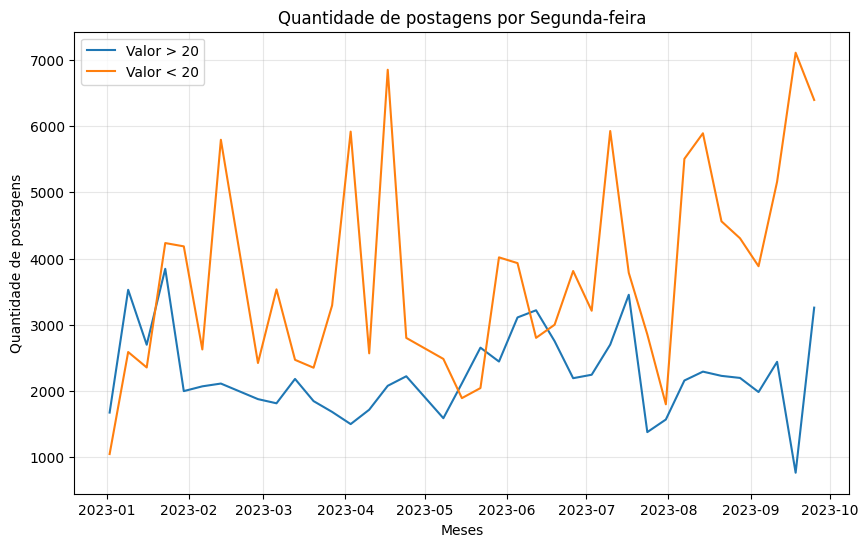

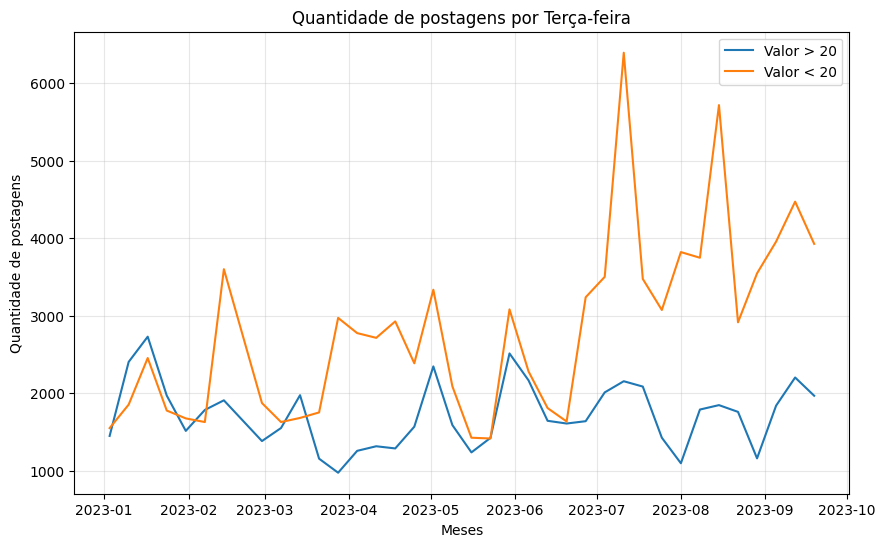

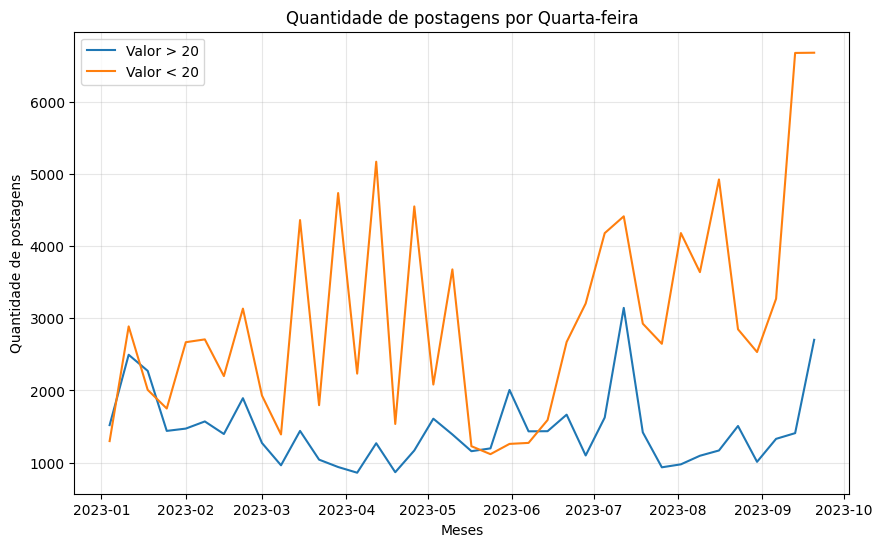

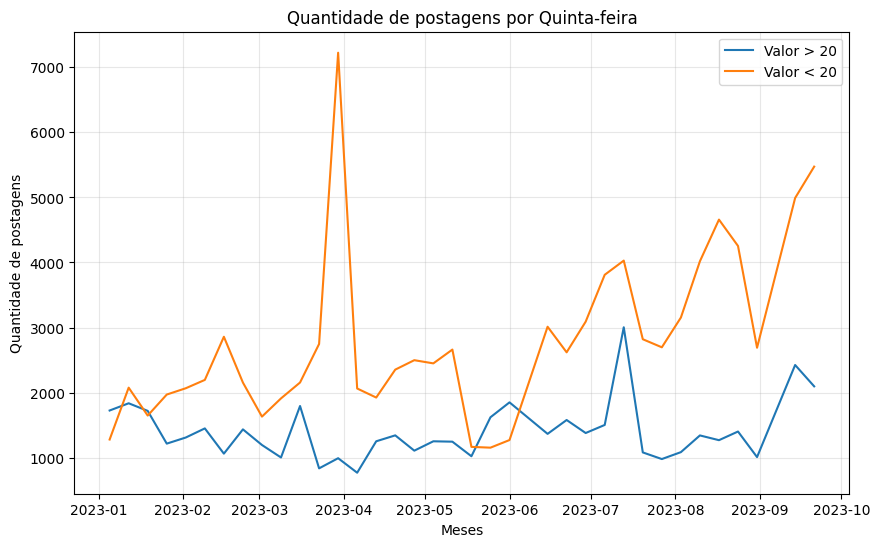

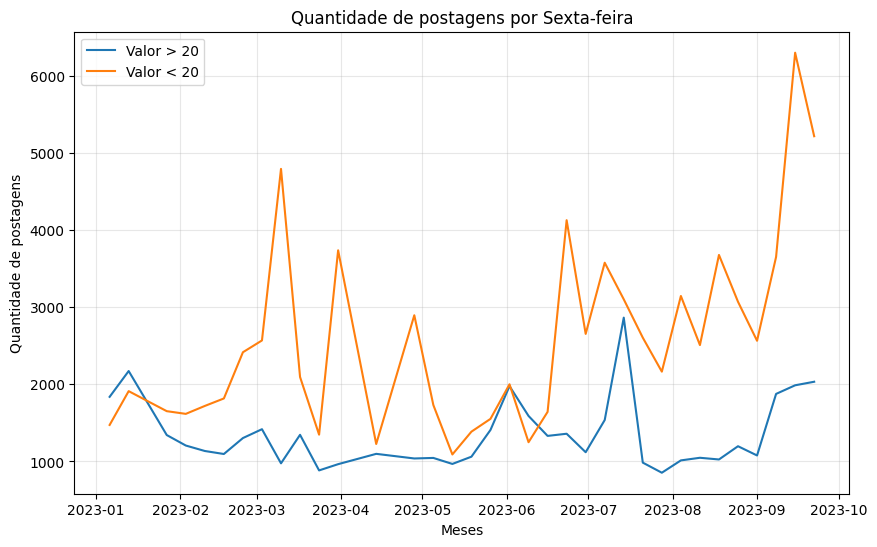

In [ ]:
dias = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira"]

for dia in dias:
    df_menores = df_thiago[(df_thiago["Dia da Semana"] == dia) & (df_thiago["Valor"] <= 20)]
    df_qtd_menores = df_menores.groupby("Data")["Data"].agg(["count"]).reset_index()
    df_qtd_menores.rename(columns={"count":"Postagens < 20"}, inplace=True)

    df_maiores = df_thiago[(df_thiago["Dia da Semana"] == dia) & (df_thiago["Valor"] > 20)]
    df_qtd_maiores = df_maiores.groupby("Data")["Data"].agg(["count"]).reset_index()
    df_qtd_maiores.rename(columns={"count":"Postagens > 20"}, inplace=True)

    datas = df_qtd_maiores["Data"]

    plt.figure(figsize=(10, 6))
    plt.grid(alpha=0.3)
    linha1, = plt.plot(datas, df_qtd_maiores["Postagens > 20"])
    linha2, = plt.plot(datas, df_qtd_menores["Postagens < 20"])
    plt.title(f"Quantidade de postagens por {dia}")
    plt.ylabel("Quantidade de postagens")
    plt.xlabel("Meses")
    linha1.set_label("Valor > 20")
    linha2.set_label("Valor < 20")
    plt.legend()
    plt.show()


### Conclui-se, nesse contexto e a partir dos gráficos, que a frequência de postagens de preço menor que 20 reais é geralmente maior na segunda, apesar de possuir alguns picos interessantes nos outros dias da semana, os quais estão provavelmente relacionados com datas festivas e momentos de maior postagem. Percebe-se também que no mês de julho houve um grande pico de postagens custando mais que 20 reais, e que em janeiro a quantidade de postagens custando mais de 20 reais é maior em todos os dias da semana. Além disso, nota-se grande pico de postagens que custam menos que 20 reais na quarta feira, o que pode estar relacionado com práticas dos cidadãos; visto que não existe um motivo óbvio relacionado com o registro dos dados. Esse comportamento pode indicar uma maior frequência de compras, por exemplo, na quarta feira, principalmente nos meses de março à junho. Por fim, entende-se que não existe relação direta entre as postagens menores/maiores que 20 reais com os dias da semana, considerando que os picos provavelmente estão relacionados com pico de compras para datas festivas. Vamos tentar analisar num escopo maior (mês) para ver se existe influência nesse sentido.

## * A média de postagens nos primeiros 15 dias é significativamente diferente da média de postagens no restante do mês?

### Incluindo os meses no dataframe

In [ ]:
df_thiago["Data"] = pd.to_datetime(df_thiago["Data"], dayfirst=True)

df_thiago['Mês'] = [valor.month for valor in df_thiago['Data']]
meses = {
        1: 'Janeiro',
        2: 'Fevereiro',
        3: 'Março',
        4: 'Abril',
        5: 'Maio',
        6: 'Junho',
        7: 'Julho',
        8: 'Agosto',
        9: 'Setembro',
        10: 'Outubro',
        11: 'Novembro',
        12: 'Dezembro'}

df_thiago['Mês'] = df_thiago['Mês'].map(meses)

df_thiago["Mês"].unique()



array(['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho',
       'Agosto', 'Setembro'], dtype=object)

### Vamos verificar agora quantas postagens por mês foram realizadas no nosso dataframe

In [ ]:
df_postagens_por_mes = df_thiago.groupby("Mês")["Mês"].agg(["count"]).reset_index().sort_values(by="count", ascending=False)
df_postagens_por_mes.rename(columns={"count":"Postagens"}, inplace=True)
df_postagens_por_mes

,Mês,Postagens
1,Agosto,122004
4,Julho,111955
8,Setembro,111129
7,Março,94384
5,Junho,90460
3,Janeiro,87083
6,Maio,79265
0,Abril,79128
2,Fevereiro,72982


### E agora vamos visualizá-las num gráfico

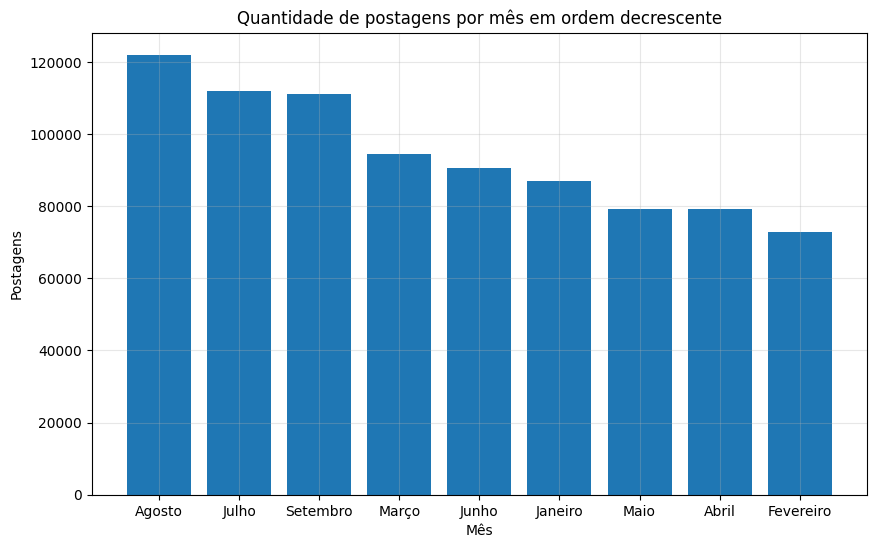

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df_postagens_por_mes["Mês"], df_postagens_por_mes["Postagens"])
plt.grid(alpha=0.3)
plt.title("Quantidade de postagens por mês em ordem decrescente")
plt.xlabel("Mês")
plt.ylabel("Postagens")
plt.show()

### Vamos agora criar dois dataframes, uma para cada momento do mês que queremos analisar

In [ ]:
df_antes_do_dia_15 = df_thiago[df_thiago["Data"].dt.day <= 15]
df_depois_do_dia_15 = df_thiago[df_thiago["Data"].dt.day > 15]


### Agora faremos a agregação desses dataframes por quantidade

In [ ]:
df_postagens_antes_de_15 = df_antes_do_dia_15.groupby("Mês")["Mês"].agg(["count"]).reset_index()
df_postagens_antes_de_15.rename(columns={"count":"Postagens"}, inplace=True)
df_postagens_antes_de_15


,Mês,Postagens
0,Abril,37638
1,Agosto,61076
2,Fevereiro,46249
3,Janeiro,38620
4,Julho,64934
5,Junho,41024
6,Maio,38651
7,Março,43707
8,Setembro,63505


In [ ]:
df_postagens_depois_de_15 = df_depois_do_dia_15.groupby("Mês")["Mês"].agg(["count"]).reset_index()
df_postagens_depois_de_15.rename(columns={"count":"Postagens"}, inplace=True)
df_postagens_depois_de_15

,Mês,Postagens
0,Abril,41490
1,Agosto,60928
2,Fevereiro,26733
3,Janeiro,48463
4,Julho,47021
5,Junho,49436
6,Maio,40614
7,Março,50677
8,Setembro,47624


### E visualizaremos esses dataframes com o gráfico para tentar concluir algo sobre isso

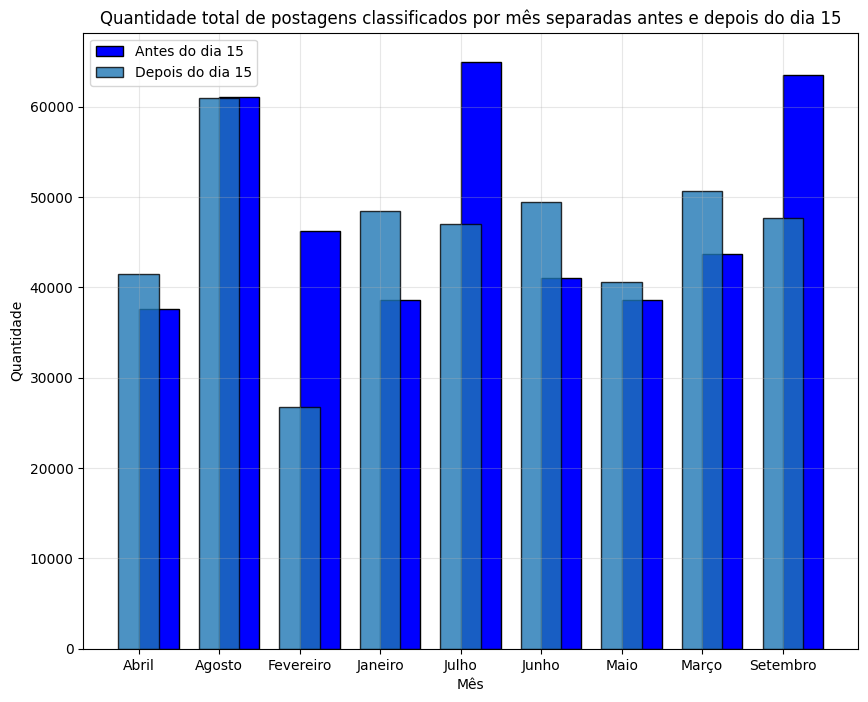

In [ ]:
plt.figure(figsize=(10,8))
plt.grid(alpha=0.3)
antes_15 = plt.bar(df_postagens_antes_de_15["Mês"], df_postagens_antes_de_15["Postagens"], color="blue", width=0.5, align="edge", edgecolor="black")
depois_15 = plt.bar(df_postagens_depois_de_15["Mês"], df_postagens_depois_de_15["Postagens"], width=0.5, alpha=0.8, edgecolor="black")
antes_15.set_label("Antes do dia 15")
depois_15.set_label("Depois do dia 15")
plt.legend()
plt.title("Quantidade total de postagens classificados por mês separadas antes e depois do dia 15")
plt.ylabel("Quantidade")
plt.xlabel("Mês")
plt.ylim()
plt.show()

### Com o gráfico podemos identificar que não parece haver padrão que indique maior quantidade de postagens antes do dia 15 dos meses de 2023. Apesar de existirem picos, é claro que geralmente está balanceado. Existe a possibilidade desses picos estarem relacionados com o momento do mês que o cidadão brasileiro recebe o salário, mas não existem informações suficientes para afirmar isso. Existe também a possibilidade dos picos antes do dia 15 estarem relacionados com festas comemorativas que aumentem o número de postagens. Conclui-se que nos meses de fevereiro, julho e setembro existem significativamente mais postagens no começo do mês do que no resto, e que no mês de agosto as postagens são praticamente iguais antes e depois do dia 15.

# 3. Análise estadual (Gabriel)

**Perguntas:**
1. Qual a distribuição do número de postagens por estado?
2. Percentualmente, o quão varia o número de postagens entre os estados do sudeste?
3. Como se caracteriza a distribuição de valores de postagem para os estados da região sudeste?
4. A média de valor dos pacotes enviados para dentro do estado do RJ é igual à média dos pacotes enviados para outros estados do Brasil?
5. A média de valor dos pacotes enviados para dentro do estado do RJ é igual à média dos pacotes enviados para outros estados do Sudeste?
6. A média de valor dos pacotes enviados para o ES é igual à média dos pacotes enviados para SP?

Verificando os estados disponíveis:

In [ ]:
# Copiando o dataframe original:
df3 = df.copy()

df3["UF"].unique()

array(['RJ', 'SC', 'ES', 'BA', 'CE', 'RS', 'SE', 'PR', 'DF', 'PI', 'PE',
       'GO', 'PA', 'MG', 'MA', 'PB', 'MS', 'RN', 'SP', 'AL', 'AP', 'MT',
       'RO', 'AM', 'RR', 'TO', 'AC', 'Ri'], dtype=object)

Existe um typo: `RJ` está grafado como `Ri` em uma das linhas. Vamos consertar:

In [ ]:
idx_erro = df3[df3["UF"] == "Ri"].index
df3.loc[idx_erro, "UF"] = "RJ"

## 3.1. Qual a distribuição do número de postagens por estado?

In [ ]:
df3["UF"].value_counts()

RJ    407427
MG     88710
ES     40113
SP     35198
GO     26378
AM     24016
RS     22393
BA     22023
PA     20061
PR     18583
MA     17848
PE     11355
PB     10705
MS      9202
DF      9114
PI      9009
CE      8765
RN      8255
SC      8244
MT      6953
RO      6725
RR      4746
TO      4740
AC      4075
SE      2731
AL      2266
AP      1699
Name: UF, dtype: int64

In [ ]:
# Criando uma lista de cores para os gráficos:
colors = [
    "#FF0000", "#00FF00", "#0000FF",
    "#FFFF00", "#FF00FF", "#00FFFF",
    "#FFA500", "#8A2BE2", "#A52A2A",
    "#7FFF00", "#D2691E", "#8B008B",
    "#556B2F", "#FFD700", "#DAA520",
    "#B8860B", "#006400", "#BDB76B",
    "#8B0000", "#2E8B57", "#8B4513",
    "#2F4F4F", "#00008B", "#708090",
    "#9ACD32", "#FF4500", "#DA70D6"
]

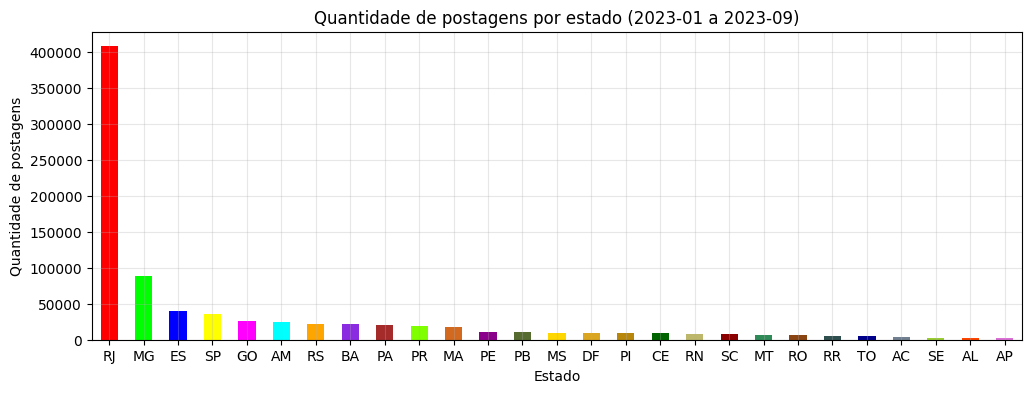

In [ ]:
plt.figure(figsize=(12,4))
df3["UF"].value_counts().plot(kind="bar", color=colors)
plt.xlabel("Estado")
plt.ylabel("Quantidade de postagens")
plt.title("Quantidade de postagens por estado (2023-01 a 2023-09)")
plt.grid(alpha=0.3)
plt.xticks(rotation=0)
plt.show()

Excluindo o RJ para uma melhor visualização:

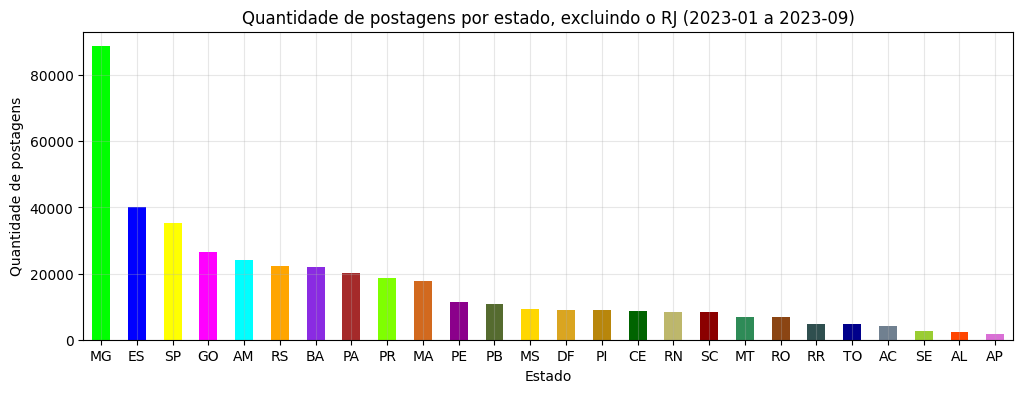

In [ ]:
plt.figure(figsize=(12,4))
df3[df3["UF"] != "RJ"]["UF"].value_counts().plot(kind="bar", color=colors[1:])
plt.xlabel("Estado")
plt.ylabel("Quantidade de postagens")
plt.title("Quantidade de postagens por estado, excluindo o RJ (2023-01 a 2023-09)")
plt.grid(alpha=0.3)
plt.xticks(rotation=0)
plt.show()

## 3.2. Percentualmente, o quão varia o número de postagens entre os estados do sudeste?

Primeiramente, vamos verificar, percentualmente, a quantidade de postagens por estado levando-se em consideração a quantidade total de entradas em nosso dataset.

In [ ]:
round((df3["UF"].value_counts()/len(df3))*100, 2)

RJ    49.01
MG    10.67
ES     4.83
SP     4.23
GO     3.17
AM     2.89
RS     2.69
BA     2.65
PA     2.41
PR     2.24
MA     2.15
PE     1.37
PB     1.29
MS     1.11
DF     1.10
PI     1.08
CE     1.05
RN     0.99
SC     0.99
MT     0.84
RO     0.81
RR     0.57
TO     0.57
AC     0.49
SE     0.33
AL     0.27
AP     0.20
Name: UF, dtype: float64

Verificamos que o número de postagens para o RJ é quase igual à soma do número de postagens para os outros estados do país.

In [ ]:
# Quantidade de postagens para o RJ:
post_rj = df3["UF"].value_counts()[0]
print(post_rj)

407427


In [ ]:
# Soma do número de postagens para outros estados:
post_outros_estados = sum(df3["UF"].value_counts()[1:])
print(post_outros_estados)

423907


In [ ]:
# Diferença em quantidade de postagens:
abs(post_outros_estados-post_rj)

16480

Em termos de diferença percentual:

In [ ]:
# Diferença percentual do número de postagens para o RJ em comparação aos outros estados do país:
round((abs(post_rj - post_outros_estados)/max(post_outros_estados, post_rj))*100, 2)

3.89

Visualmente:

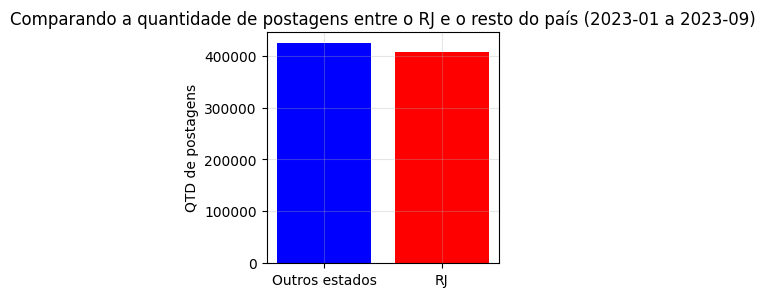

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(["Outros estados", "RJ"], [post_outros_estados, post_rj], color=["blue", "red"])
plt.ylabel("QTD de postagens")
plt.title("Comparando a quantidade de postagens entre o RJ e o resto do país (2023-01 a 2023-09)")
plt.grid(alpha=0.3)
plt.show()

Comparando agora entre os estados do sudeste:

In [ ]:
post_se = df3["UF"].value_counts()[0:4]
post_se

RJ    407427
MG     88710
ES     40113
SP     35198
Name: UF, dtype: int64

In [ ]:
for i in range(len(post_se)-1):
  print(f"Diferença do número de postagens do {post_se.index[i]} para {post_se.index[i+1]}: ", end='')
  dif = post_se.values[i] - post_se.values[i+1]
  dif_percent = round((dif/post_se.values[i])*100, 2)
  print(f"{dif} ({dif_percent}%)")

Diferença do número de postagens do RJ para MG: 318717 (78.23%)
Diferença do número de postagens do MG para ES: 48597 (54.78%)
Diferença do número de postagens do ES para SP: 4915 (12.25%)


## 3.3. Como se caracteriza a distribuição de valores de postagem para os estados da região sudeste?

Plotando um histograma para cada estado da região sudeste representando a frequência dos valores de postagem:

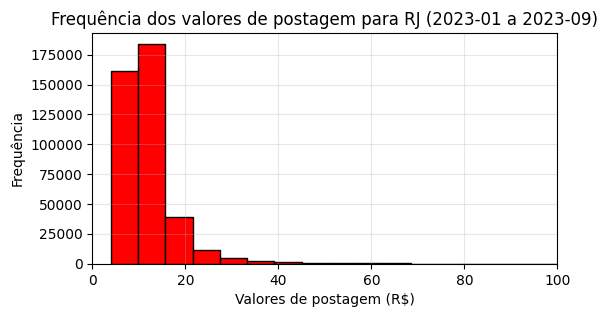

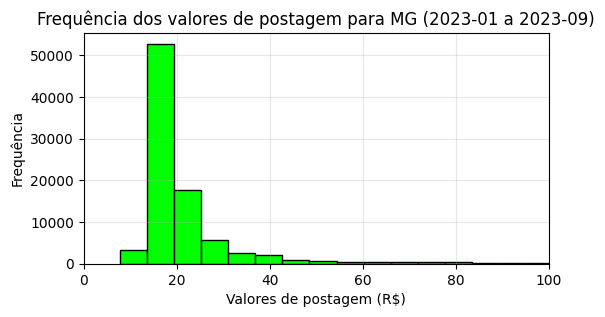

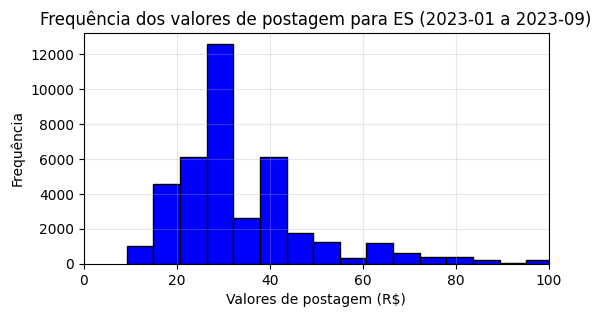

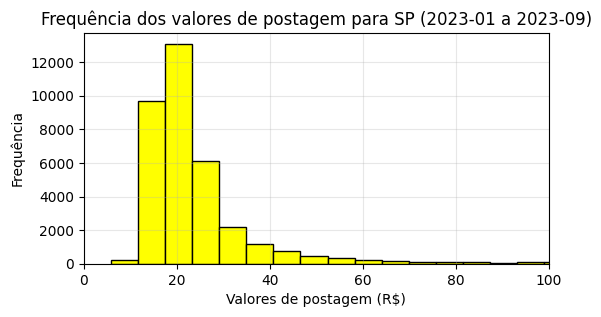

In [ ]:
i = 0
for e in ["RJ","MG","ES","SP"]:
  plt.figure(figsize=(6,3))
  df3[df3["UF"] == e]["Valor"].plot(kind="hist", bins=50, edgecolor="black", color=colors[i])
  plt.xlabel("Valores de postagem (R$)")
  plt.ylabel("Frequência")
  plt.title(f"Frequência dos valores de postagem para {e} (2023-01 a 2023-09)")
  plt.grid(alpha=0.3)
  plt.xlim(0,100)
  plt.show()
  i += 1

## 3.4. A média de valor dos pacotes enviados para dentro do estado do RJ é igual à média dos pacotes enviados para outros estados do Brasil?

* Hipótese nula ($H_{0}$): a média de valor dos pacotes enviados para dentro do RJ é igual à média dos pacotes enviados para outros estados do Brasil.
* Hipótese alternativa ($H_{1}$): a média de valor dos pacotes enviados para dentro do estado do RJ é diferente da média dos pacotes enviados para outros estados do Brasil.

In [ ]:
# Separar os valores de pacotes enviados para dentro do RJ e para outros estados
valores_rj = df3[df3['UF'] == 'RJ']['Valor']
valores_outros = df3[df3['UF'] != 'RJ']['Valor']

# Realizar o teste t para as médias das duas amostras
t_stat, p_value = stats.ttest_ind(valores_rj, valores_outros)

print(f"t_stat: {t_stat}\np_value: {p_value}")

t_stat: -472.05187686401666
p_value: 0.0


Como o `p_value` é extremamente baixo (praticamente 0), podemos rejeitar a hipótese nula ($H_{0}$). **Isso sugere que a média de valor dos pacotes enviados para dentro do estado do RJ é, de fato, diferente da média dos pacotes enviados para outros estados do país**.

Visualizando:

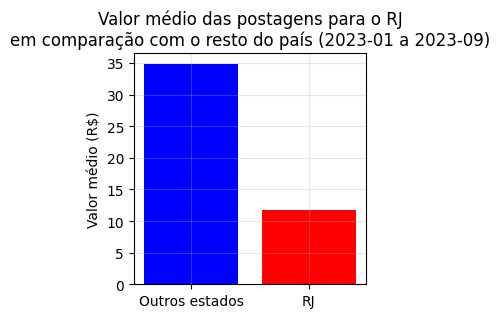

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(["Outros estados", "RJ"], [valores_outros.mean(), valores_rj.mean()], color=["blue", "red"])
plt.ylabel("Valor médio (R$)")
plt.title("Valor médio das postagens para o RJ\nem comparação com o resto do país (2023-01 a 2023-09)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
[valores_outros.mean(), valores_rj.mean()]

[34.79405657372963, 11.807273229314704]

## 3.5. A média de valor dos pacotes enviados para dentro do estado do RJ é igual à média dos pacotes enviados para outros estados do Sudeste?

* Hipótese nula ($H_{0}$): a média de valor dos pacotes enviados para dentro do RJ é igual à média dos pacotes enviados para outros estados do Sudeste.
* Hipótese alternativa ($H_{1}$): a média de valor dos pacotes enviados para dentro do RJ é diferente da média dos pacotes enviados para outros estados do Sudeste.

In [ ]:
valores_rj = df3[df3['UF'] == 'RJ']['Valor']

filtro = (df3['UF'] == 'MG') | (df3['UF'] == 'ES') | (df3['UF'] == 'SP')
valores_outros = df3[filtro]['Valor']

t_stat, p_value = stats.ttest_ind(valores_rj, valores_outros)

print(f"t_stat: {t_stat}\np_value: {p_value}")

t_stat: -416.29486824166895
p_value: 0.0


Novamente, o `p_value` é praticamente 0. Assim, podemos rejeitar a hipótese nula ($H_{0}$). **Isso sugere que a média de valor dos pacotes enviados para dentro do estado do RJ é, de fato, diferente da média dos pacotes enviados para outros estados do Sudeste**.

Visualizando:

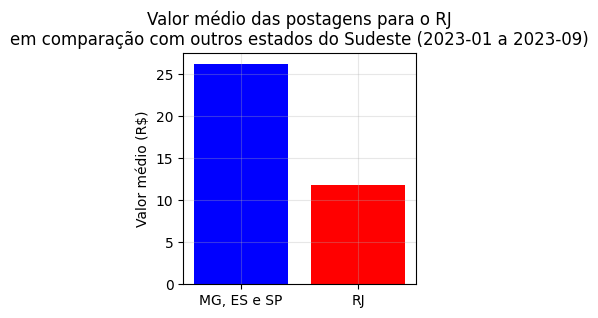

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(["MG, ES e SP", "RJ"], [valores_outros.mean(), valores_rj.mean()], color=["blue", "red"])
plt.ylabel("Valor médio (R$)")
plt.title("Valor médio das postagens para o RJ\nem comparação com outros estados do Sudeste (2023-01 a 2023-09)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
[valores_outros.mean(), valores_rj.mean()]

[26.128152919443245, 11.807273229314704]

## 3.6. A média de valor dos pacotes enviados para o ES é igual à média dos pacotes enviados para SP?

* Hipótese nula ($H_{0}$): a média de valor dos pacotes enviados para o ES é igual à média dos pacotes enviados para SP.
* Hipótese alternativa ($H_{1}$): a média de valor dos pacotes enviados para o ES é diferente da média dos pacotes enviados para SP.

In [ ]:
valores_es = df3[df3['UF'] == 'ES']['Valor']
valores_sp = df3[df3['UF'] == 'SP']['Valor']

t_stat, p_value = stats.ttest_ind(valores_es, valores_sp)

print(f"t_stat: {t_stat}\np_value: {p_value}")

t_stat: 84.17489115080836
p_value: 0.0


`p_value` é praticamente 0 $\implies$ rejeição da hipótese nula ($H_{0}$).

**Isso sugere que a média de valor dos pacotes enviados para o ES é, de fato, diferente da média dos pacotes enviados para SP**.

Visualizando:

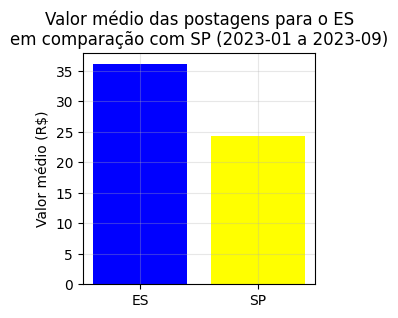

In [ ]:
plt.figure(figsize=(3,3))
plt.bar(["ES", "SP"], [valores_es.mean(), valores_sp.mean()], color=["blue", "yellow"])
plt.ylabel("Valor médio (R$)")
plt.title("Valor médio das postagens para o ES\nem comparação com SP (2023-01 a 2023-09)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
[valores_es.mean(), valores_sp.mean()]

[36.09462269089821, 24.38086539007898]

Note como o valor de `abs(t_stat)` é menor nesse caso em comparação com os valores obtidos nas seções 3.4 e 3.5. **Esse valor nos dá uma medida da diferença entre as médias das duas amostras em termos de erros padrão**. Nesse caso, vemos que a diferença das médias de valores para ES e SP é menor do que a diferença das médias do RJ em comparação tanto com o resto do país quanto com os outros estados da região sudeste.

# 4. Análise regional (Ruann)

**Visualizações e Perguntas Trabalhadas:**
1. Gráfico do Valor Médio do Envio por Região
2.  valor médio de envio da região Norte é igual ao valor médio de envio da região Nordeste?
3. E para as outras regiões? A região Norte apresenta um valor médio igual ao valor médio das outras regiões?
4. O valor médio de envio da região Centro-Oeste é igual ao valor médio de envio da região Sul?
5. Distribuição da Quantidade de Envios por Regiões

In [2]:
import numpy as np
# df = pd.read_parquet(r'/content/drive/MyDrive/Colab Notebooks/operations_base.parquet')
# df

In [7]:
# Gerando uma cópia do dataframe original
df_regiao = df.copy()

Detectando e tratando linha com erro no UF, que estava Ri e na verdade é RJ

In [8]:
df_regiao.loc[df['UF'] == 'Ri']

,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF
797110,15/09/2023,VF323300731RJ,25225660,EXPRESSO,0.00,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
807975,18/09/2023,VF021858638RJ,20511190,EXPRESSO,20.03,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
807976,18/09/2023,VF350169628RJ,22061080,EXPRESSO,58.64,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
807977,18/09/2023,VF350176664RJ,20511170,EXPRESSO,20.03,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
807978,18/09/2023,VF021858814RJ,21041150,EXPRESSO,51.24,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
808138,18/09/2023,VF350169176RJ,21615340,EXPRESSO,35.04,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
808139,18/09/2023,VF021858876RJ,23885000,EXPRESSO,50.08,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri
812416,19/09/2023,VF372065444RJ,21863428,EXPRESSO,21.24,CLIENTE SEM CONTRATO,AUTOMÁTICO,RIO DE JANEIRO,Ri


In [9]:
df_regiao.loc[812416,'UF'] = 'RJ'
df_regiao['UF'].value_counts()

UF
RJ    415669
MG     90604
ES     40255
SP     36546
GO     26740
AM     24330
RS     22955
BA     22445
PA     20554
PR     18776
MA     18473
PE     11543
PB     10826
MS      9465
DF      9287
PI      9197
CE      9043
RN      8483
SC      8480
MT      7165
RO      6951
RR      4857
TO      4828
AC      4150
SE      2759
AL      2284
AP      1718
Ri         7
Name: count, dtype: int64

In [10]:
# Gerando a coluna Região e agrupando os estados de acordo com as suas regiões correspondentes
df_regiao['Regiao'] = [
    'Norte' if item in ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'] else
    'Nordeste' if item in ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'] else
    'Centro-Oeste' if item in ['DF', 'GO', 'MS', 'MT'] else
    'Sudeste' if item in ['ES', 'MG', 'RJ', 'SP'] else
    'Sul' if item in ['PR', 'RS', 'SC'] else ''
    for item in df['UF']
]

In [11]:
df_regiao.head(5)

,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF,Regiao
0,02/01/2023,QW184224840RJ,27143610,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Sudeste
1,02/01/2023,QW184224874RJ,26160210,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Sudeste
2,02/01/2023,QW184224868RJ,23535370,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Sudeste
3,02/01/2023,QW184224893RJ,27321640,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Sudeste
4,02/01/2023,QW184227030RJ,23530816,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ,Sudeste


In [12]:
# Calculando a média dos valores de envio das regiões
media_regiao = df_regiao[['Regiao', 'Valor']] \
                        .groupby(['Regiao']) \
                        .agg({'Valor' : np.average})

media_regiao.reset_index(inplace = True)
media_regiao = media_regiao.iloc[1:]
media_regiao.rename(columns = {'Valor' : 'Valor_Médio_Regiao'}, inplace = True)
media_regiao.rename(columns = {'Regiao' : 'Regiao'}, inplace = True)

In [13]:
media_regiao

,Regiao,Valor_Médio_Regiao
1,Centro-Oeste,29.406464
2,Nordeste,45.854566
3,Norte,55.371675
4,Sudeste,15.981771
5,Sul,28.173270


**1. Gráfico do Valor Médio do Envio por Região**

In [14]:
import plotly.express as px

# Ordenando o DataFrame
media_regiao = round(media_regiao.sort_values(by='Valor_Médio_Regiao', ascending=False),2)

# Criando o gráfico com plotly
fig = px.bar(
    media_regiao,
    x='Regiao',
    y='Valor_Médio_Regiao',
    color='Regiao'
)

# Definindo legendas e título
fig.update_layout(
    xaxis=dict(title='Região'),
    yaxis=dict(title='Valor Médio Ticket'),
    title='Gráfico do Valor Médio do Envio por Região'
)


# Mostrando o gráfico
fig.show()

*    **2. O valor médio de envio da região Norte é igual ao valor médio de envio da região Nordeste?**

* Hipótese nula ($H_{0}$): O valor médio de envio da região Norte é igual ao valor médio de envio da região Nordeste.
* Hipótese alternativa ($H_{1}$): O valor médio de envio da região Norte é diferente do valor médio de envio da região Nordeste.

In [ ]:
# Pegando as amostras das Regiões Norte e das demais regiões do país
valores_Norte = df_regiao[df_regiao['Regiao'] == 'Norte']['Valor']
valores_Nordeste = df_regiao[df_regiao['Regiao'] != 'Nordeste']['Valor']

# Realizar o teste t para as médias das duas amostras
t_stat_regiao, p_value_regiao = stats.ttest_ind(valores_Norte, valores_Nordeste)

# Fazendo uma condição para analisar se o p-valor é menor do que o valor de significância padrão de 5%
if p_value_regiao < 0.05:
    print(f"Há evidências para rejeitar a hipótese nula - {p_value_regiao}")
else:
    print(f"Não há evidências para rejeitar a hipótese nula - {p_value_regiao}")

Há evidências para rejeitar a hipótese nula - 0.0



**Se o valor-p (p-value) é igual a 0, há indícios de que há evidências extremamente fortes para rejeitar a hipótese nula. Portanto, podemos concluir que o valor médio de envio da região Norte é significativamente diferente do valor médio de envio da região Nordeste com base na amostra analisada.**

**3. E para as outras regiões? A região Norte apresenta um valor médio igual ao valor médio das outras regiões?**

* Hipótese nula ($H_{0}$): O valor médio de envio da região Norte é igual ao valor médio de envio das outras regiões.
* Hipótese alternativa ($H_{1}$): O valor médio de envio da região Norte é diferente do valor médio de envio das outras regiões.

In [ ]:
# Pegando as amostras das Regiões Norte e Nordeste
valores_Norte = df_regiao[df_regiao['Regiao'] == 'Norte']['Valor']
valores_Nordeste = df_regiao[df_regiao['Regiao'] != 'Norte']['Valor']

# Realizar o teste t para as médias das duas amostras
t_stat_regiao, p_value_regiao = stats.ttest_ind(valores_Norte, valores_Nordeste)

# Fazendo uma condição para analisar se o p-valor é menor do que o valor de significância padrão de 5%
if p_value_regiao < 0.05:
    print(f"Há evidências para rejeitar a hipótese nula - {p_value_regiao}")
else:
    print(f"Não há evidências para rejeitar a hipótese nula - {p_value_regiao}")

Há evidências para rejeitar a hipótese nula - 0.0


**Como o valor-p (p-value) é igual a 0, há indícios de que há evidências extremamente fortes para rejeitar a hipótese nula. Portanto, podemos concluir que o valor médio de envio da região Norte é significativamente diferente do valor médio de envio das outras regiões do Brasil.**

*    **4. O valor médio de envio da região Centro-Oeste é igual ao valor médio de envio da região Sul?**

* Hipótese nula ($H_{0}$): O valor médio de envio da região Centro-Oeste é igual ao valor médio de envio da região Sul.
* Hipótese alternativa ($H_{1}$): O valor médio de envio da região Centro-Oeste é diferente do valor médio de envio da região Sul.

In [ ]:
# Pegando as amostras das Região Centro-Oeste e da Região Sul
valores_Centro_Oeste = df_regiao[df_regiao['Regiao'] == 'Centro-Oeste']['Valor']
valores_Sul = df_regiao[df_regiao['Regiao'] == 'Sul']['Valor']

# Realizar o teste t para as médias das duas amostras
t_stat_regiao, p_value_regiao = stats.ttest_ind(valores_Centro_Oeste, valores_Sul)

# Fazendo uma condição para analisar se o p-valor é menor do que o valor de significância padrão de 5%
if p_value_regiao < 0.05:
    print(f"Há evidências para rejeitar a hipótese nula - {p_value_regiao}")
else:
    print(f"Não há evidências para rejeitar a hipótese nula - {p_value_regiao}")

Há evidências para rejeitar a hipótese nula - 8.743952606223933e-20


**O resultado indica que o valor-p (p_value_regiao) é extremamente baixo (praticamente zero), o que fornece evidências significativas para rejeitar a hipótese nula. Portanto, conclui-se que há diferenças estatisticamente significativas entre o valor médio de envio da Região Centro-Oeste e o valor médio de envio da Região Sul.**

**5. Distribuição de Envios por Regiões**

In [15]:
# Calculando a porcentagem de envios para cada região
porcentagens = round(df_regiao['Regiao'].value_counts(normalize=True) * 100, 2)

# Criando o gráfico de barras com o plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=porcentagens.index,
    y=porcentagens.values,
    marker=dict(color='skyblue'),
    textposition='auto'
))

# Adicionando a linha de distribuição
fig.add_trace(go.Scatter(
    x=porcentagens.index,
    y=porcentagens.values,
    mode='lines',
    line=dict(color='black', width=2),  # Cor e largura da linha
    name='Linha de Distribuição'
))

# Adicionando rótulos e títulos
fig.update_layout(
    xaxis=dict(title='Regiões'),
    yaxis=dict(title='Porcentagem'),
    title='Distribuição da Quantidade de Envios por Regiões',
)

# Mostrando o gráfico
fig.show()